In [1]:
import numpy as np
import matplotlib.pyplot as plt
import svglib

In [2]:
with np.load('../resources/river_network.npz') as data:
    height = data["height"]
    land_mask = data["land_mask"]

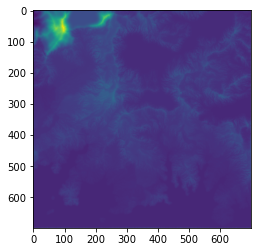

In [3]:
plt.imshow(height)

# SVG reading

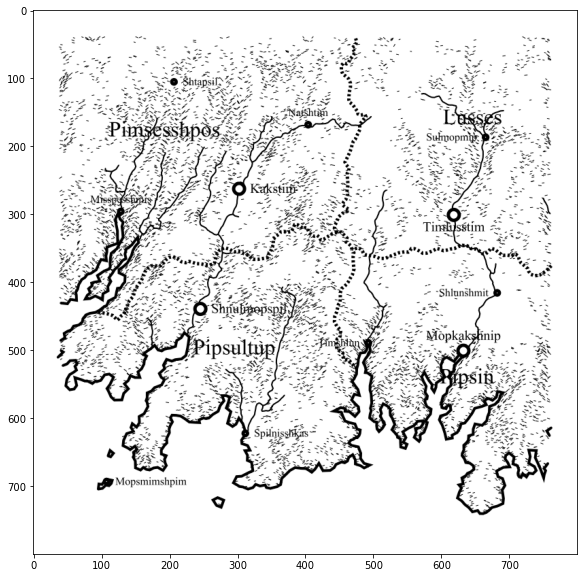

In [4]:
from svglib.svglib import svg2rlg
import io
from reportlab.graphics import renderPDF, renderPM
import PIL.Image
import reportlab

sscale = 2

drawing = svg2rlg("../resources/pen.svg")
drawing.scale(sscale, sscale)
drawing.width *= sscale
drawing.height *= sscale
# renderPDF.drawToFile(drawing, "file.pdf")
buffer = io.BytesIO()
renderPM.drawToFile(drawing, buffer, fmt="PNG")
img = PIL.Image.open(buffer)
plt.figure(figsize=(10,10))
plt.imshow(img)

In [5]:
from reportlab.graphics.shapes import *

class SVGExtractor:
    def __init__(self, drawing_path, scale=2):
        self.drawing_path = drawing_path
        self.scale = scale
        self.load_drawing()
    
    def load_drawing(self):
        self.drawing = svg2rlg("../resources/pen.svg")
        self.drawing.scale(self.scale, self.scale)
        self.drawing.width *= self.scale
        self.drawing.height *= self.scale

    def get_cls(self, svgclass, key=None, value=None):
        self.load_drawing()
        shape_group = self.drawing.contents[0]
        contents = shape_group.contents
        new_contents = []
        for shape in contents:
            if isinstance(shape, Group):
                obj = shape.contents[0]
                if isinstance(obj, svgclass):
                    if key:
                        if obj.__dict__[key] == value:
                            obj.__dict__[key] = 1.
                            new_contents.append(shape)
                    else:
                        new_contents.append(shape)
            elif isinstance(shape, svgclass):
                new_contents.append(shape)

        shape_group.contents = new_contents
        self.drawing.contents = [shape_group]
        return self.drawing
    
    def show(self):
        buffer = io.BytesIO()
        renderPM.drawToFile(self.drawing, buffer, fmt="PNG")
        img = PIL.Image.open(buffer)
        plt.figure(figsize=(10,10))
        plt.imshow(img)
        return img

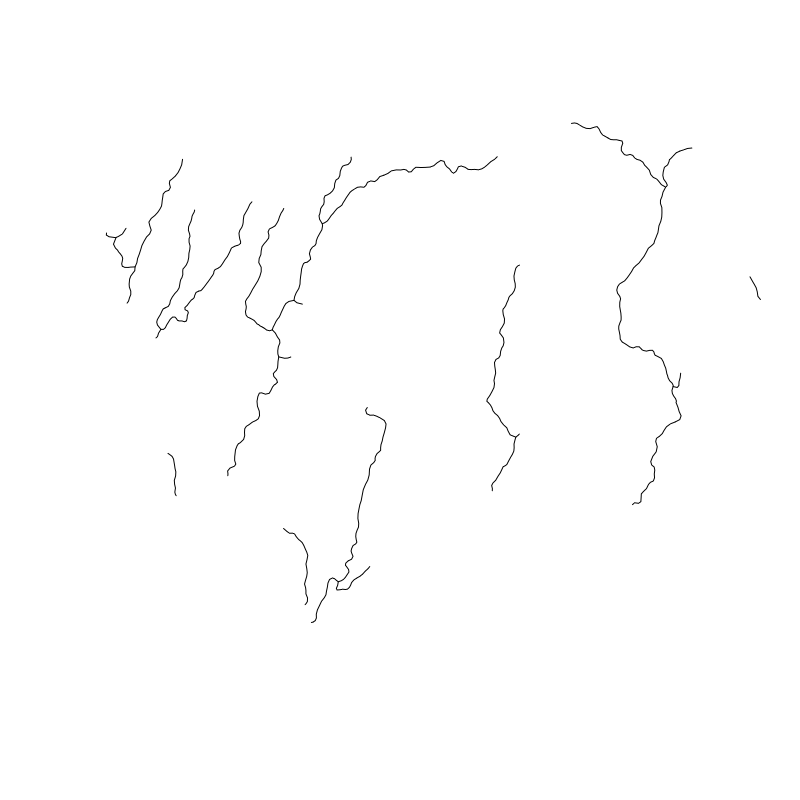

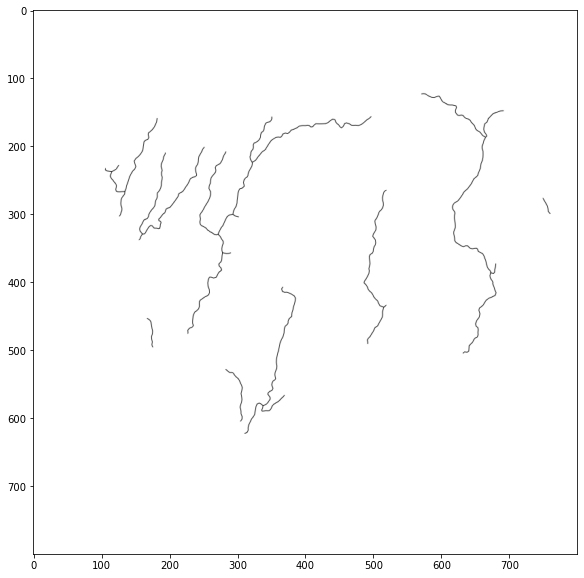

In [6]:
extractor = SVGExtractor("../resources/pen.svg")
extractor.get_cls(Path, "strokeWidth", 2.0)
extractor.show()

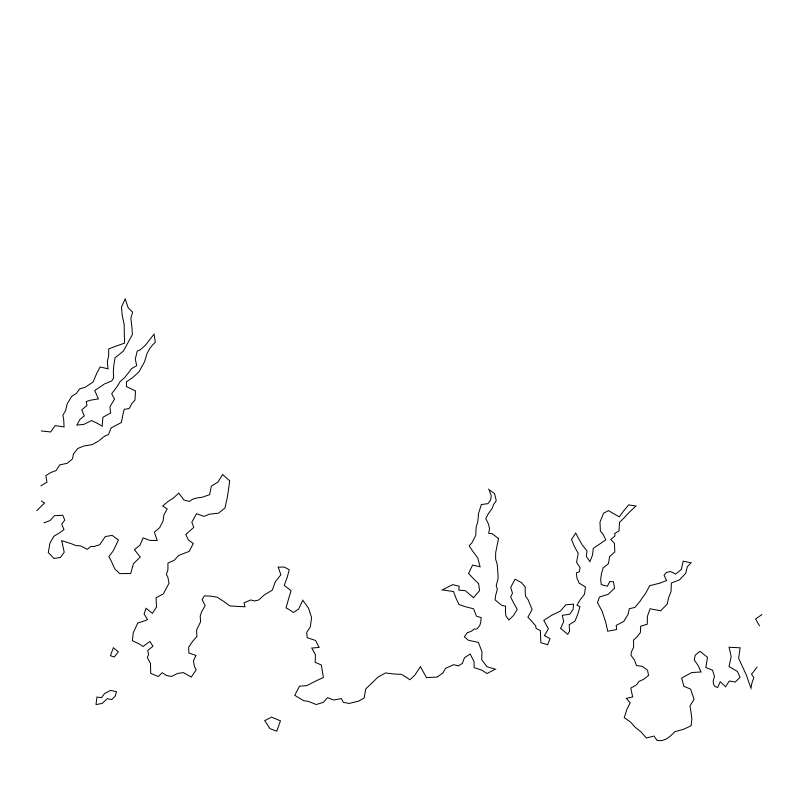

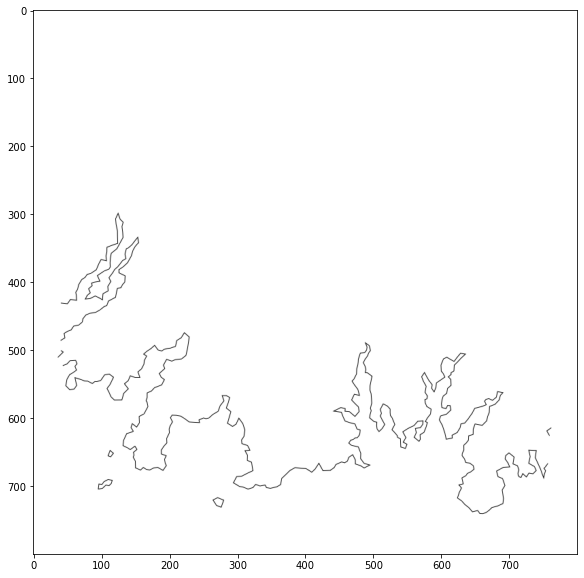

In [7]:
extractor = SVGExtractor("../resources/pen.svg")
extractor.get_cls(Path, "strokeWidth", 4.0)
extractor.show()

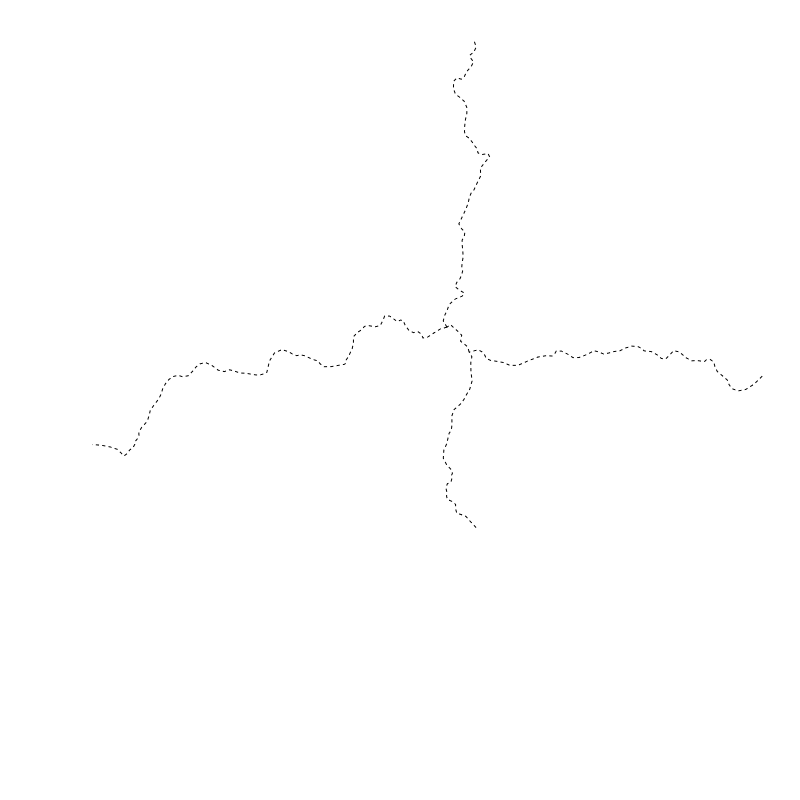

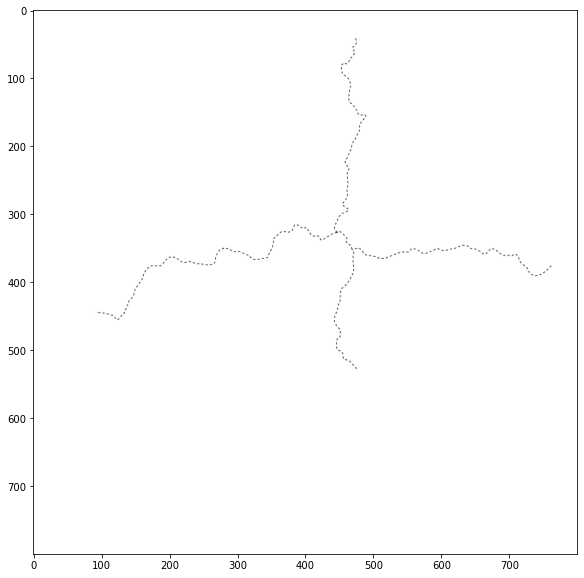

In [8]:
extractor = SVGExtractor("../resources/pen.svg")
extractor.get_cls(Path, "strokeWidth", 5.0)
extractor.show()

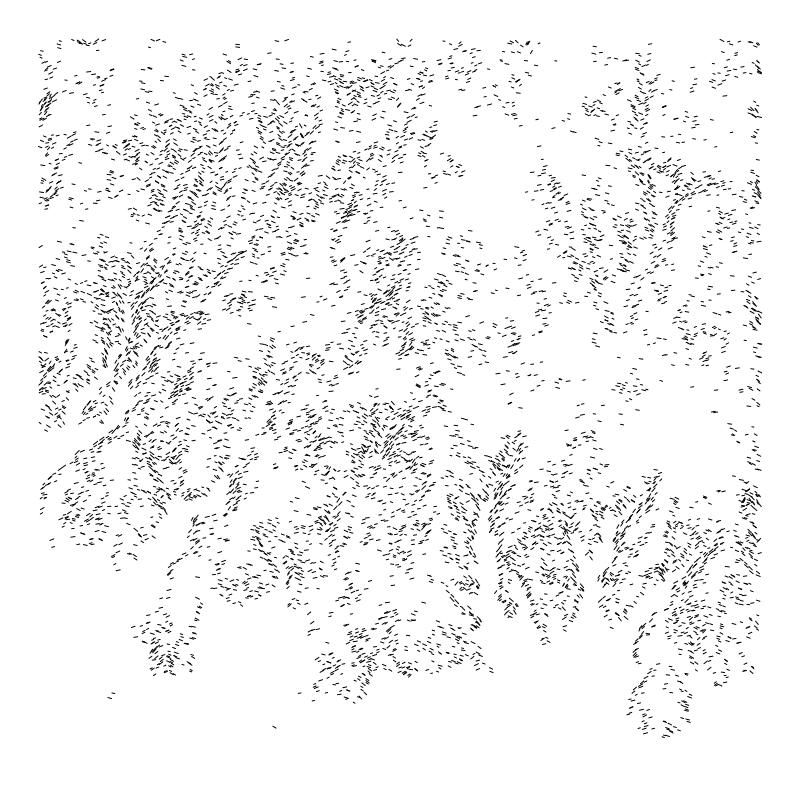

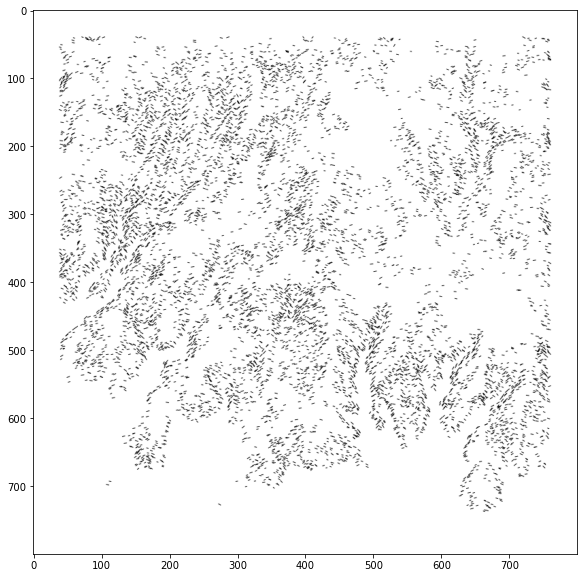

In [9]:
extractor = SVGExtractor("../resources/pen.svg")
extractor.get_cls(Line)
extractor.show()

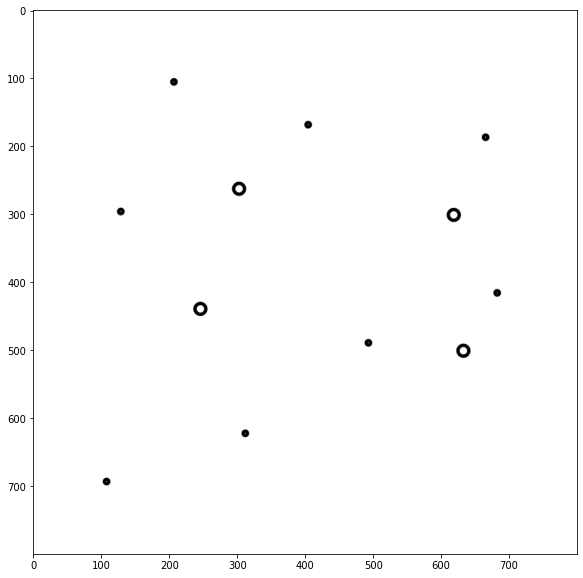

In [17]:
extractor = SVGExtractor("../resources/pen.svg")
extractor.get_cls(Circle, "strokeWidth", 2.0)
extractor.show()

# fill

In [18]:
extractor = SVGExtractor("../resources/pen.svg")
drawing = extractor.get_cls(Path, "strokeWidth", 4.0)
buffer = io.BytesIO()
renderPM.drawToFile(drawing, buffer, fmt="PNG")
img = PIL.Image.open(buffer)

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, filters, color, morphology
from skimage.segmentation import flood, flood_fill

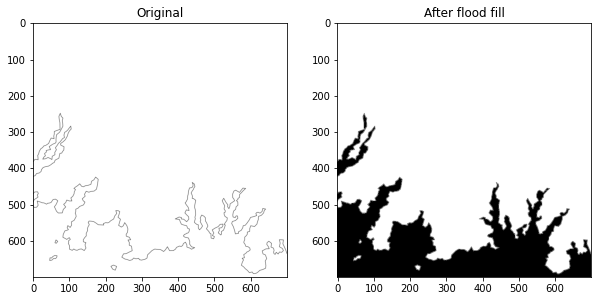

In [20]:
padding = 50
data = np.asarray(img)[padding:-padding,padding:-padding,0]
# Fill a square near the middle with value 127, starting at index (76, 76)
filled_checkers = flood_fill(data, (600, 1), 0)
filled_checkers = flood_fill(filled_checkers, (400, 1), 0)
filled_checkers = flood_fill(filled_checkers, (280, 80), 0)
filled_checkers = flood_fill(filled_checkers, (480, 1), 0)

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

ax[0].imshow(data, cmap=plt.cm.gray)
ax[0].set_title('Original')

ax[1].imshow(filled_checkers, cmap=plt.cm.gray)
ax[1].set_title('After flood fill')

plt.show()

# script

In [23]:
import sys
sys.path.append('../terrain-erosion-3-ways/')
from river_network import *
import png

In [24]:
dim = 700
shape = (dim,) * 2
disc_radius = 1.0
max_delta = 0.04
river_downcutting_constant = 1.3
directional_inertia = 0.4
default_water_level = 1.0
evaporation_rate = 0.2

print ('Generating...')

print('  ...initial terrain shape')
land_mask = remove_lakes(
  (util.fbm(shape, -2, lower=2.0) + bump(shape, 0.2 * dim) - 1.1) > 0)
land_mask = filled_checkers > 0
coastal_dropoff = np.tanh(util.dist_to_mask(land_mask) / 80.0) * land_mask
mountain_shapes = util.fbm(shape, -2, lower=2.0, upper=np.inf)
initial_height = ( 
  (util.gaussian_blur(np.maximum(mountain_shapes - 0.40, 0.0), sigma=5.0) 
    + 0.1) * coastal_dropoff)
deltas = util.normalize(np.abs(util.gaussian_gradient(initial_height))) 

print('  ...sampling points')
points = util.poisson_disc_sampling(shape, disc_radius)
coords = np.floor(points).astype(int)

Generating...
  ...initial terrain shape
  ...sampling points


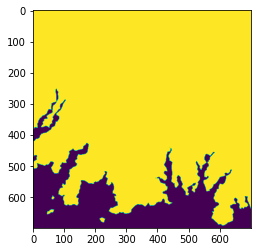

In [25]:
plt.imshow(land_mask)

In [26]:
print('  ...delaunay triangulation')
tri = sp.spatial.Delaunay(points)
(indices, indptr) = tri.vertex_neighbor_vertices
neighbors = [indptr[indices[k]:indices[k + 1]] for k in range(len(points))]
points_land = land_mask[coords[:, 0], coords[:, 1]]
points_deltas = deltas[coords[:, 0], coords[:, 1]]

print('  ...initial height map')
points_height = compute_height(points, neighbors, points_deltas)

print('  ...river network')
(upstream, downstream, volume) = compute_river_network(
  points, neighbors, points_height, points_land,
  directional_inertia, default_water_level, evaporation_rate)

print('  ...final terrain height')
new_height = compute_final_height(
  points, neighbors, points_deltas, volume, upstream, 
  max_delta, river_downcutting_constant)
terrain_height = render_triangulation(shape, tri, new_height)


  ...delaunay triangulation
  ...initial height map
  ...river network
  ...final terrain height


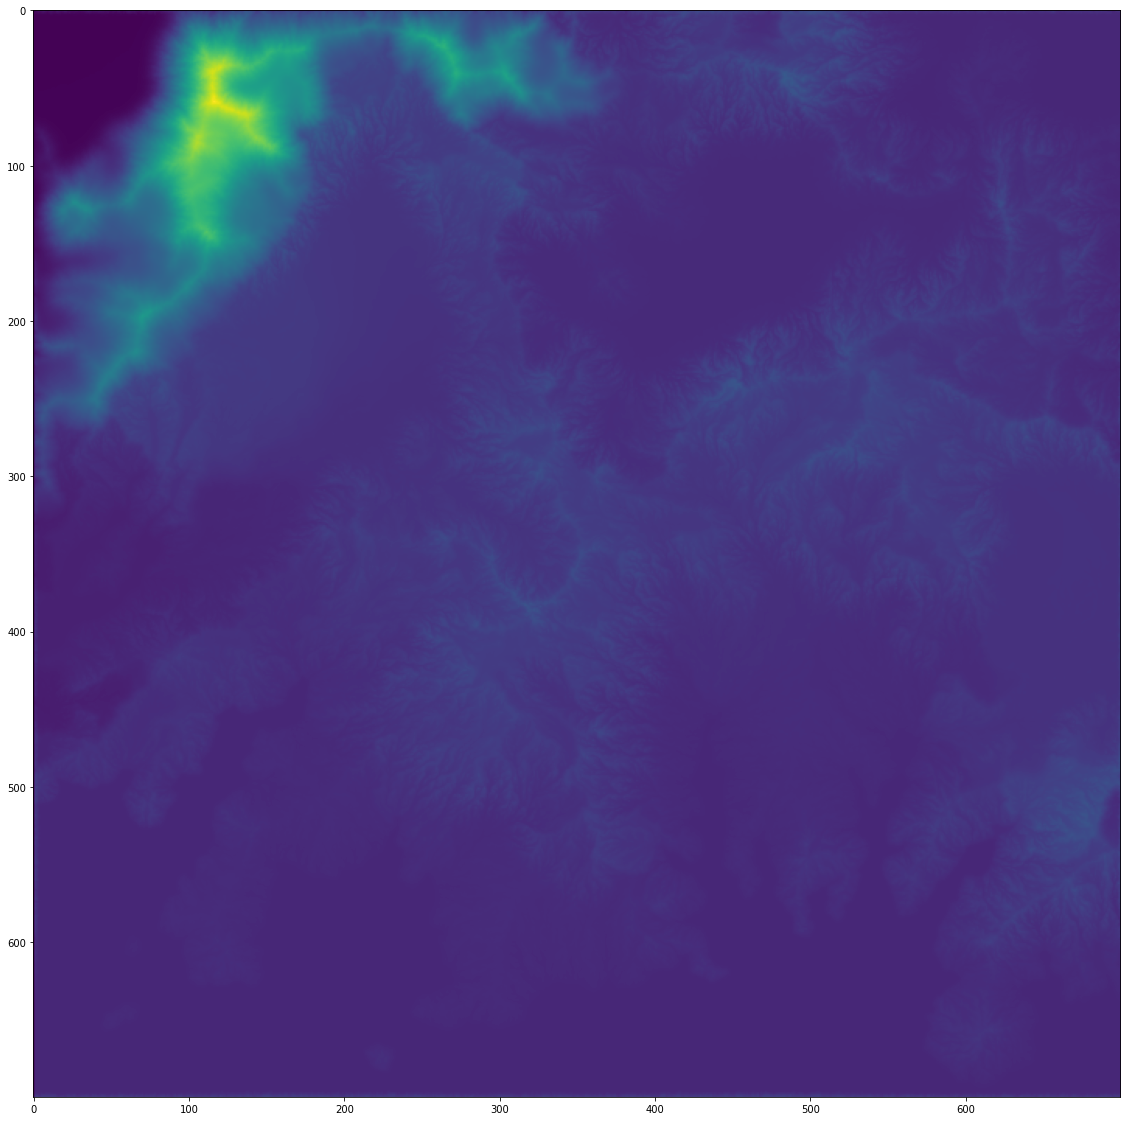

In [27]:
plt.figure(figsize=(20,20))
plt.imshow(terrain_height)

In [28]:
qmap = (terrain_height*255).astype(np.uint8)

In [29]:
qimg = PIL.Image.fromarray(qmap).convert('L')
qimg.save("../output/test_total.png")

In [ ]:
for i in range(3):
    for j in range(3):
        x_start = 256*i
        y_start = 256*j
        x_end = min(qmap.shape[1]-1, 256*(i+1))
        y_end = min(qmap.shape[0]-1, 256*(j+1))

        png.from_array(qmap[y_start:y_end,x_start:x_end], 'L').save(f"../output/test_{i}_{j}.png")
